# Introduction
In this document we will estimate the Total Orders of 25 consecutive weeks by exploiting information about

* Total Orders

* Market Excitation Orders

* New Entrants Orders

* Frequent Saver Orders

* Frequent Saver Members

* Twelve Week Active Customers

We will

1. Plot each values to identify particular trends or periodicity

2. Analyze correlation between each negative translations of provided segments and Total Orders to find some relationships

3. Select both best set of features and best model by evaluating some performances indexes

4. Consider some techniques bases on signal analysis and evaluate their performances 

5. Make the requested prediction by using the best model


# Data Loading and Preparation
We firstly load some useful libraries.

In [ ]:
library(ggplot2)
library(lattice)
library(caret)
library(forecast)

options(warn=-1)

We load data from csv file and separate the first 175 rows that will be used for the correlation analysis and to train and test models. 

In [ ]:
data<-read.csv("Online_Forecasting_Data.csv",
               header=TRUE,sep=";",colClasses="integer")[1:200,]
corr_study<-data[1:175,]

# Trend Analysis
In this first section we simply plot all measures to better understand the problem.

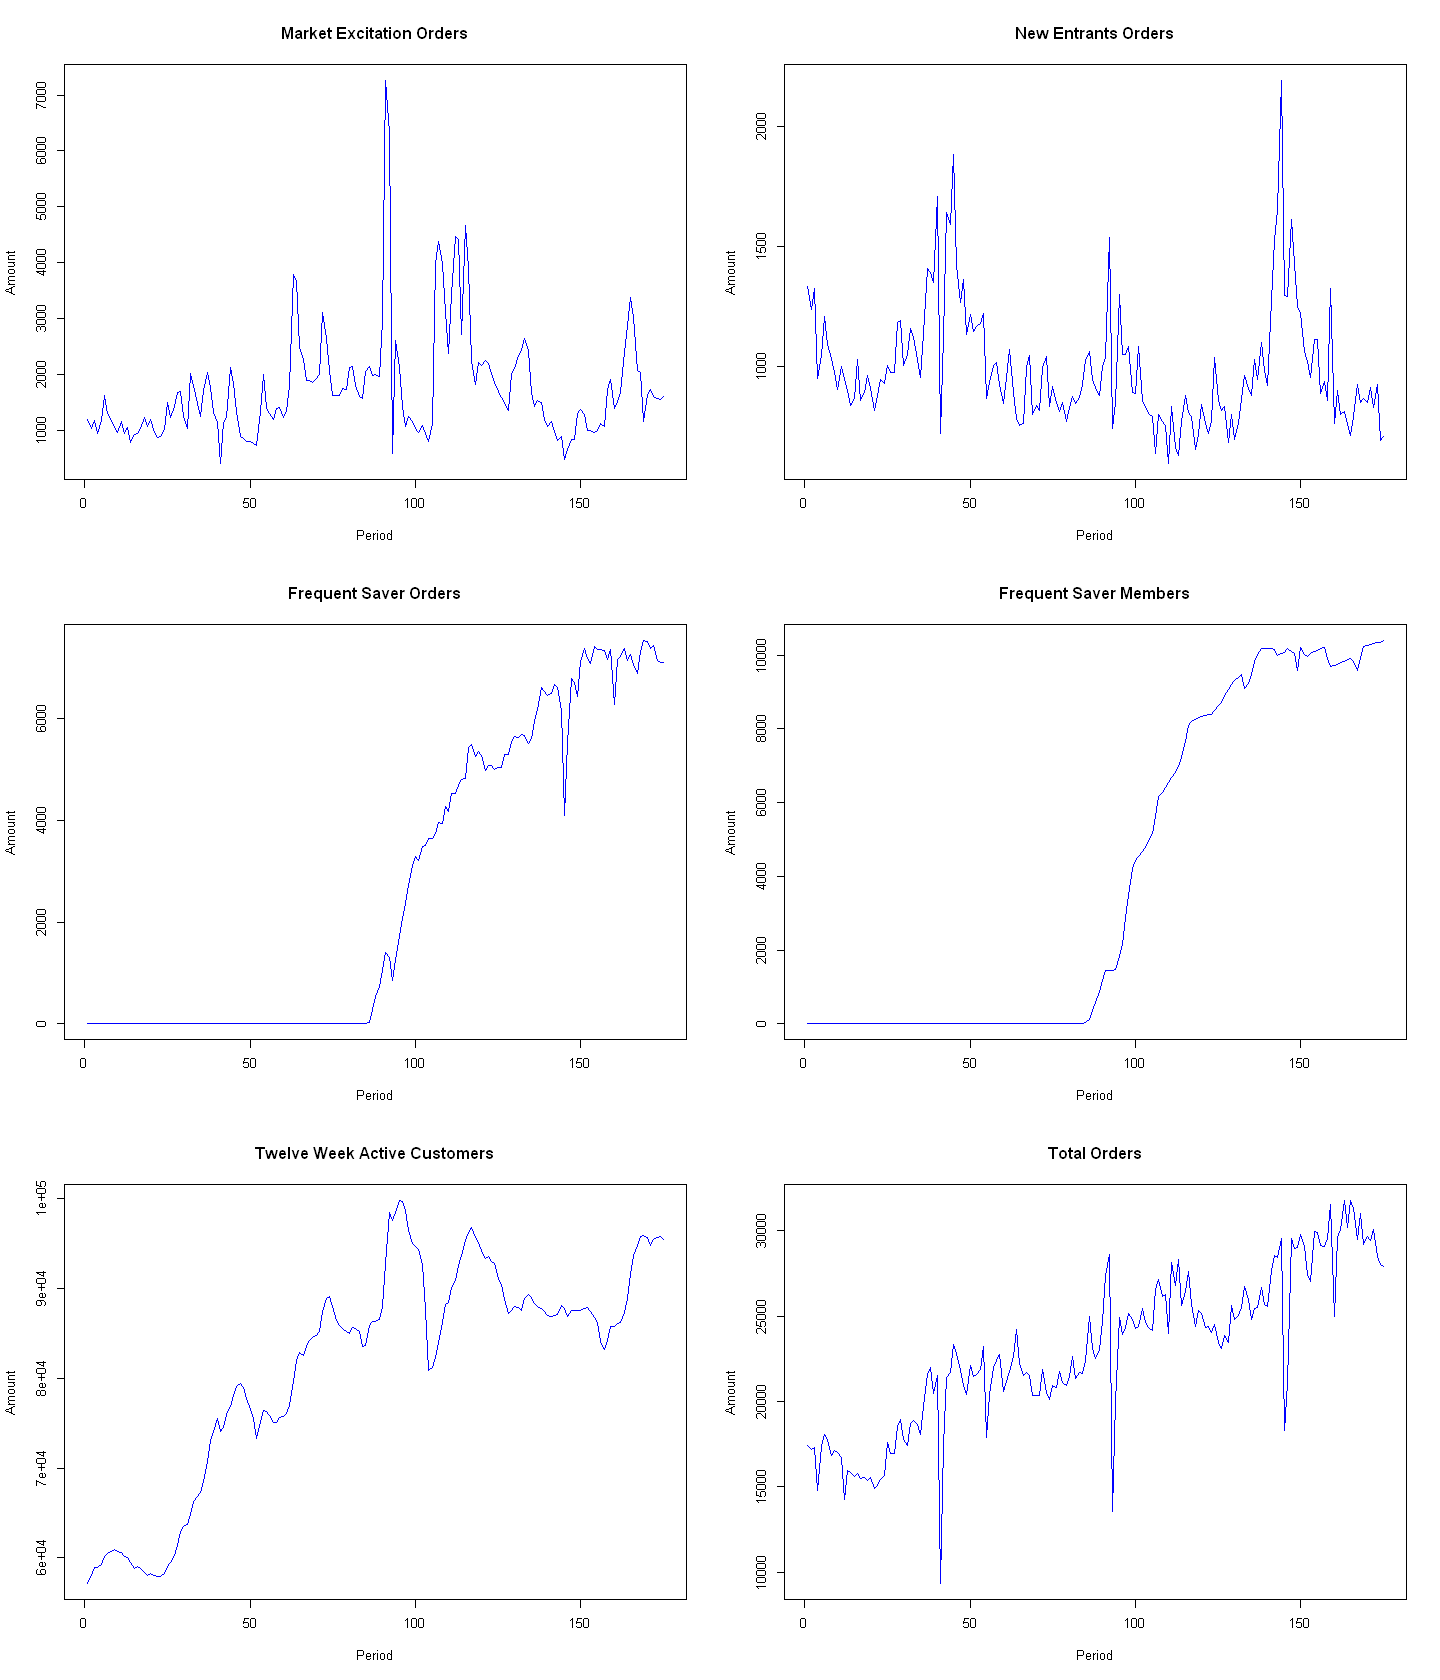

In [ ]:
options(repr.plot.width=12, repr.plot.height=14)
par(mfrow=c(3,2)) 

plot(corr_study$Market_Excitation_Orders,type='line',
    col='blue',main='Market Excitation Orders',
    xlab='Period',ylab='Amount')
plot(corr_study$New_Entrants_Orders,type='line',
    col='blue',main='New Entrants Orders',
    xlab='Period',ylab='Amount')
plot(corr_study$Frequent_Saver_Orders,type='line',
    col='blue',main='Frequent Saver Orders',
    xlab='Period',ylab='Amount')
plot(corr_study$Frequent_Saver_Members,type='line',
    col='blue',main='Frequent Saver Members',
    xlab='Period',ylab='Amount')
plot(corr_study$Twelve_Week_Active_Customers,type='line',
    col='blue',main='Twelve Week Active Customers',
    xlab='Period',ylab='Amount')
plot(corr_study$Total_Orders,type='line',
    col='blue',main='Total Orders',
    xlab='Period',ylab='Amount')

We notice that:

* There is a 52-periods periodicity in NEO values and it generates the same periodicity in TO values. For this reason, the period *n-52* should have values very similar to the period *n* for each *n*. So TO(-52) will be a good feature to train our model.

* In TO chart there is also a long period trend. In order to correctly model it we will need to use as feature the past TO values of at least 2 years i.e. TO(-52) and TO(-104).

* FSO e FSM are very similar. For this reason, we can use as feature only one of them. We choose FSM because its values are given for the last 25 periods too.

* There are no periodicities in MEO, FSO, FSM and TWAC so we will use as features only the negative time translations that will be mainly correlated with TO.

# Identification of features
In this section we will analyze correlation to understand what features and which of their negative time translations mainly influence Total Orders.
The following function returns the absolute value of the correlation between a segment and the negative time translations of another segment.

In [ ]:
#delta_max=max number of negative translations to consider

delta_corr<-function(measure,feature,delta_max=110){
  #we do not compute cor between 2-length vectors
  max_index<-ifelse(delta_max<=length(measure)-3,
                    delta_max,length(measure)-3)
  measure_f<-measure
  feature_f<-feature
  res<-data.frame(neg_translation=0:max_index,cor=NA)
  res$cor[1]=abs(cor(measure_f,feature_f)) #index=0
  
  for (i in 2:(max_index+1)){
    measure_f=measure_f[-1]
    feature_f=feature_f[-length(feature_f)]
    res$cor[i]=abs(cor(measure_f,feature_f)) #index=i-1
  }
  return(res)
}

We compute and plot correlation between Total Orders and all other segments.

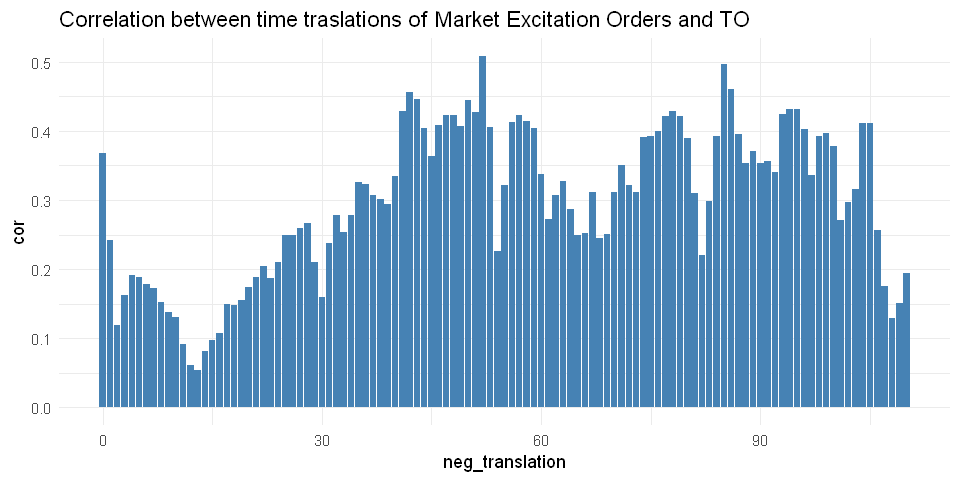

In [ ]:
options(repr.plot.width=8, repr.plot.height=4)

res<-delta_corr(corr_study$Total_Orders,
                corr_study$Market_Excitation_Orders)
p<-ggplot(data=res, aes(x=neg_translation, y=cor)) +
   geom_bar(stat="identity", fill="steelblue")+
   ggtitle("Correlation between time traslations of Market Excitation Orders and TO")+
   theme_minimal()
p #top indexes 52,86

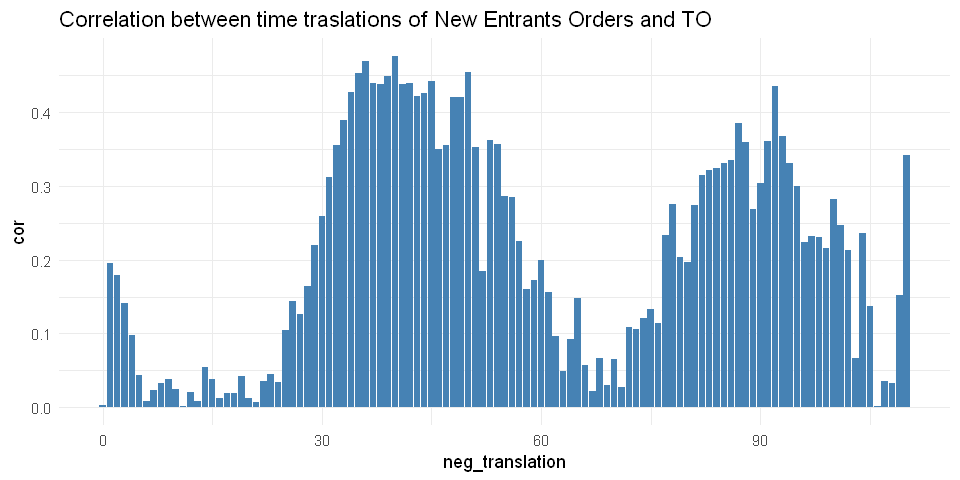

In [ ]:
res<-delta_corr(corr_study$Total_Orders,
                corr_study$New_Entrants_Orders)
p<-ggplot(data=res, aes(x=neg_translation, y=cor)) +
   geom_bar(stat="identity", fill="steelblue")+
   ggtitle("Correlation between time traslations of New Entrants Orders and TO")+
   theme_minimal()
p #top indexes 40,92

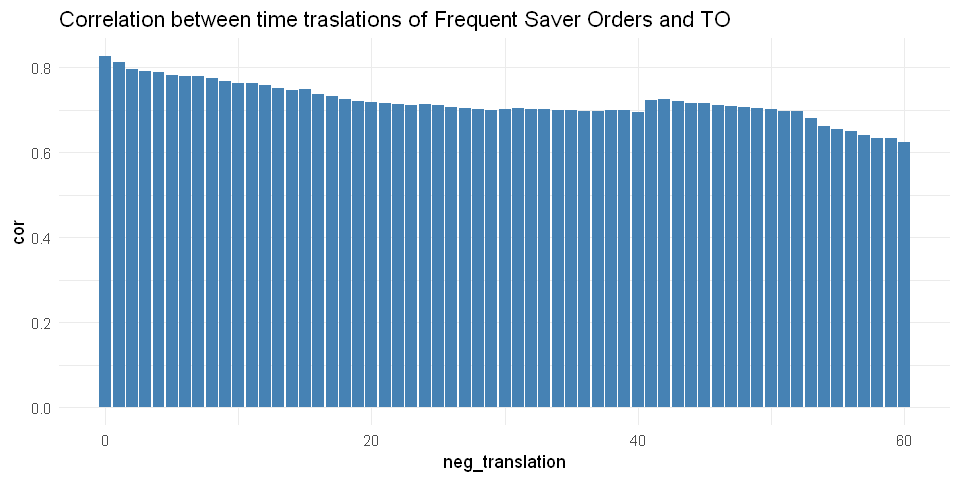

In [ ]:
res<-delta_corr(corr_study$Total_Orders,
                corr_study$Frequent_Saver_Orders,
                60) #the initial part of vector is 0
p<-ggplot(data=res, aes(x=neg_translation, y=cor)) +
   geom_bar(stat="identity", fill="steelblue")+
   ggtitle("Correlation between time traslations of Frequent Saver Orders and TO")+
   theme_minimal()
p #top indexes 0,1

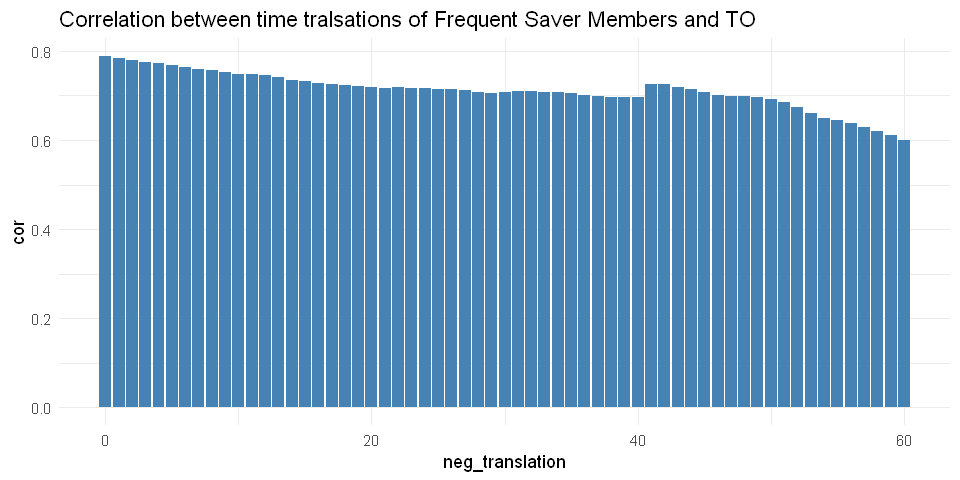

In [ ]:
res<-delta_corr(corr_study$Total_Orders,
                corr_study$Frequent_Saver_Members,
                60) #the initial part of vector is 0
p<-ggplot(data=res, aes(x=neg_translation, y=cor)) +
   geom_bar(stat="identity", fill="steelblue")+
   ggtitle("Correlation between time tralsations of Frequent Saver Members and TO")+
   theme_minimal()
p #top indexes 0,1

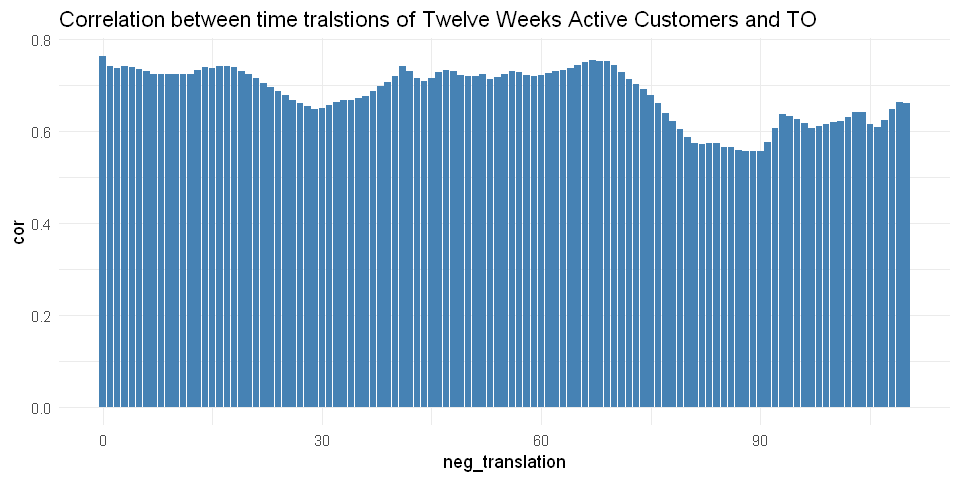

In [ ]:
res<-delta_corr(corr_study$Total_Orders,
                corr_study$Twelve_Week_Active_Customers)
p<-ggplot(data=res, aes(x=neg_translation, y=cor)) +
   geom_bar(stat="identity", fill="steelblue")+
   ggtitle("Correlation between time tralstions of Twelve Weeks Active Customers and TO")+
   theme_minimal()
p #top indexes 41,67

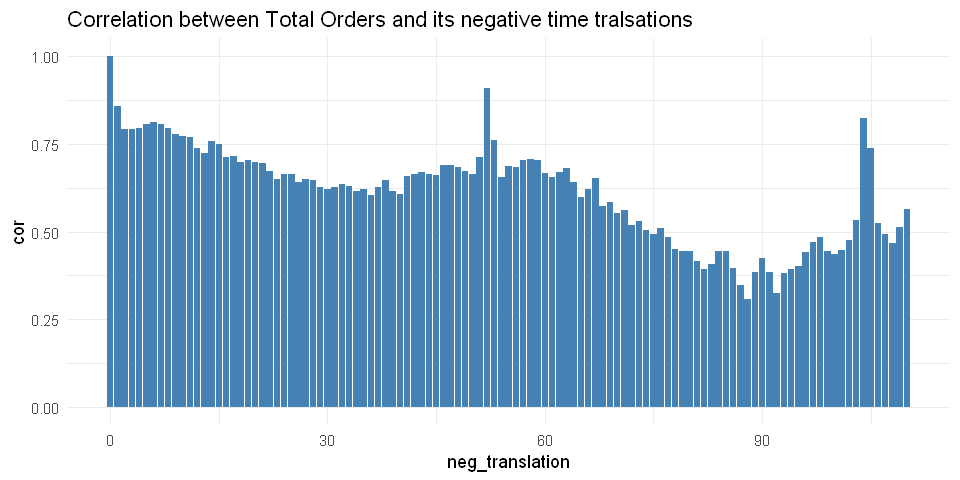

In [ ]:
res<-delta_corr(corr_study$Total_Orders,
                corr_study$Total_Orders)
p<-ggplot(data=res, aes(x=neg_translation, y=cor)) +
   geom_bar(stat="identity", fill="steelblue")+
   ggtitle("Correlation between Total Orders and its negative time tralsations")+
   theme_minimal()
p #top indexes 0,52,104

For the sake of simplicity, we want to build a unique model to estimate all the 25 unknown values of Total Orders. Because of that, we can select as features for our model 

* all the negative time translations of MEO and FSM because we have their values for the final 25 periods too

* only the negative time translations with an index grater than 24 of the other segments

Moreover, we will avoid selecting too large indexes because it would force us to have fewer rows in the dataset that we will use to train machine learning models.

A further proof of the fact that we can use only FSM information because its trend is very similar to the FSO one is that the correlation between them is very high.

In [ ]:
cor(corr_study$Frequent_Saver_Orders,corr_study$Frequent_Saver_Members)

[1] 0.9912514


By analyzing the previous charts, we can say that the values that affect more the TO are the following:

* for Market Excitation Orders indexes 0, 52 and 86

* for New Entrants Orders indexes 40 and 92

* for Frequent Saver Members indexes 0 and 1

* for Twelve Week Active Customers indexes 41 and 67

* for Total Orders indexes 0, 52, 53, 104 and 105

We notice there is often a strong correlation associated to indexes 52 and 104. It is due to the periodicity we saw in the second section.

# Training Set and Test Set Preparation
In order to test statistic models, we modify dataset to have in each row the value of the Total Orders of a period and the features that we identified in the previous section.

We decide to use the first 150 rows as training set and the rows from 151 to 175 as test set because

* it provides us a case very similar to the problem that we want to solve where we have 25 consecutive values to estimate

* we need at least 104 periods (2 years) to make model learn long period trend

In [ ]:
data_ml<-data.frame(Total_Orders=data$Total_Orders[106:200],
                    Market_Excitation_Orders_52=data$Market_Excitation_Orders[54:148],
                    Market_Excitation_Orders=data$Market_Excitation_Orders[106:200],
                    New_Entrants_Orders_40=data$New_Entrants_Orders[66:160],
                    Frequent_Saver_Members=data$Frequent_Saver_Members[106:200],
                    Twelve_Week_Active_Customers_41=data$Twelve_Week_Active_Customers[65:159],
                    Total_Orders_52=data$Total_Orders[54:148],
                    Total_Orders_53=data$Total_Orders[53:147],
                    Total_Orders_104=data$Total_Orders[2:96],
                    Total_Orders_105=data$Total_Orders[1:95]
                   )

training_ml<-data_ml[1:45,]
test_ml<-data_ml[46:70,]
to_predict<-data_ml[71:95,]

#create .csv with the modified dataset
write.csv(data_ml,"Modified_Dataset.csv",row.names=FALSE)

## Features Selection
In order to find the best set of features to train the model and avoid underfitting or overfitting, we will consider the following subsets:

1. MEO_52, MEO, NEO_40, FSM, TWAC_41, TO_52, TO_53, TO_104, TO_105

2. MEO, FSM, TO_52, TO_53, TO_104, TO_105

3. MEO, FSM, TO_52, TO_104, TO_105

4. MEO, TO_52, TO_104, TO_105

5. MEO, TO_52, TO_104

We made the groups by considering 

* the correlation we computed in the previous charts.

* the values of p-value of a linear regression model with all features

Every model will be trained with all the subsets of features. The best model and set of features will be chosen by seeing the performances with the test set.


# Cost Function
The aim of our prediction is to plan labor and inform changes to our delivery network. For these reasons, we want the estimates to be as similar as possible to the real values. Moreover, we assume that it is better to overestimate workload rather than underestimating it. Because of that we will prefer estimates that are higher than the real value rather than estimates that are lower. The criteria that we will consider to evaluate the performance of a model are the following, ordered by importance:

1. low MSE

2. high percentage of estimates in a +-8% interval of the real values

3. high correlation

4. in case of wrong estimates, we prefer them to be higher than real values

The following function allows to compute all of the previous information.

In [ ]:
#returns c(MSE, cor, % of correct pred, % of upper pred)
prec_index<- function(prediction,real,percentage=0.05){
    upper_bound<-real*(1+percentage)
    lower_bound<-real*(1-percentage)
    upper_values<-sum(prediction>upper_bound)
    inter_values<-sum(prediction<upper_bound & prediction>lower_bound)
    res<-c(inter_values,upper_values)/length(real)
    MSE<-sum((prediction-real)^2)/length(real)
    res<-c(MSE,cor(prediction,real),res)
    return(res)
}

# Model selection
We will test some different models with the 5 proposed subsets of features. The tuning of models parameters will be automatically made by caret package.

In [ ]:
#list of the columns to consider in the subsets
feat_sub<-list(1:10,c(1,3,5,7,8,9,10),c(1,3,5,7,9,10),
               c(1,3,7,9,10),c(1,3,7,9))
model<-NULL  #name of model
subset<-NULL #number of feature subset
MSE<- NULL #mean squared error
correl<-NULL   #correlation between pred and real values
inter_pred<-NULL # % of predictions in the interval
upper_pred<-NULL # % of pred larger than 1.05*real value

#linear regression
for (i in 1:length(feat_sub)){
    lr<-lm(Total_Orders~.,data=training_ml[,feat_sub[[i]]])
    val<-prec_index(round(predict(lr,newdata=test_ml[,feat_sub[[i]]])),
                    test_ml$Total_Orders)
    model<-c(model,"Linear Regression")
    subset<-c(subset,i)
    MSE<-c(MSE,val[1])
    inter_pred<-c(inter_pred,val[3])
    correl<-c(correl,val[2])
    upper_pred<-c(upper_pred,val[4])
}

#random forest
for (i in 1:length(feat_sub)){
    rf<-train(Total_Orders~.,data=training_ml[,feat_sub[[i]]],
             method="rf")
    val<-prec_index(round(predict(rf,newdata=test_ml[,feat_sub[[i]]])),
                    test_ml$Total_Orders)
    model<-c(model,"Random Forest")
    subset<-c(subset,i)
    MSE<-c(MSE,val[1])
    inter_pred<-c(inter_pred,val[3])
    correl<-c(correl,val[2])
    upper_pred<-c(upper_pred,val[4])
}

#svmLinear
for (i in 1:length(feat_sub)){
    svm<-train(Total_Orders~.,data=training_ml[,feat_sub[[i]]],
             method="svmLinear", preProcess = c('scale'))
    val<-prec_index(round(predict(svm,newdata=test_ml[,feat_sub[[i]]])),
                    test_ml$Total_Orders)
    model<-c(model,"SVM")
    subset<-c(subset,i)
    MSE<-c(MSE,val[1])
    inter_pred<-c(inter_pred,val[3])
    correl<-c(correl,val[2])
    upper_pred<-c(upper_pred,val[4])
}

#neural_network
for (i in 1:length(feat_sub)){
    nn <- train(Total_Orders~., data=training_ml[,feat_sub[[i]]],
                method = 'nnet', preProcess = c('scale'),
               linout=1, trace=FALSE)
    val<-prec_index(round(predict(nn,newdata=test_ml[,feat_sub[[i]]])),
                    test_ml$Total_Orders)
    model<-c(model,"Neural Network")
    subset<-c(subset,i)
    MSE<-c(MSE,val[1])
    inter_pred<-c(inter_pred,val[3])
    correl<-c(correl,val[2])
    upper_pred<-c(upper_pred,val[4])
}

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



In [ ]:
perf<-data.frame(Model=model,Subset=subset,MSE=MSE,
                 Inter_pred=inter_pred,Correl=correl,
                 Upper_pred=upper_pred)
perf[order(perf$MSE),]

,Model,Subset,MSE,Inter_pred,Correl,Upper_pred
11,SVM,1,1060296,0.92,0.74178117,0.04
14,SVM,4,1144503,0.88,0.73412192,0.04
3,Linear Regression,3,1158561,0.88,0.72642069,0.04
4,Linear Regression,4,1166196,0.88,0.72549791,0.04
1,Linear Regression,1,1204332,0.92,0.71842853,0.04
2,Linear Regression,2,1232991,0.88,0.70258423,0.04
12,SVM,2,1267787,0.88,0.69635990,0.04
13,SVM,3,1339008,0.88,0.71771025,0.04
5,Linear Regression,5,1802528,0.88,0.64437056,0.04
15,SVM,5,1857173,0.80,0.64262751,0.04



In order to visualize results, we now show predictions of the top 3 models compared to real values.

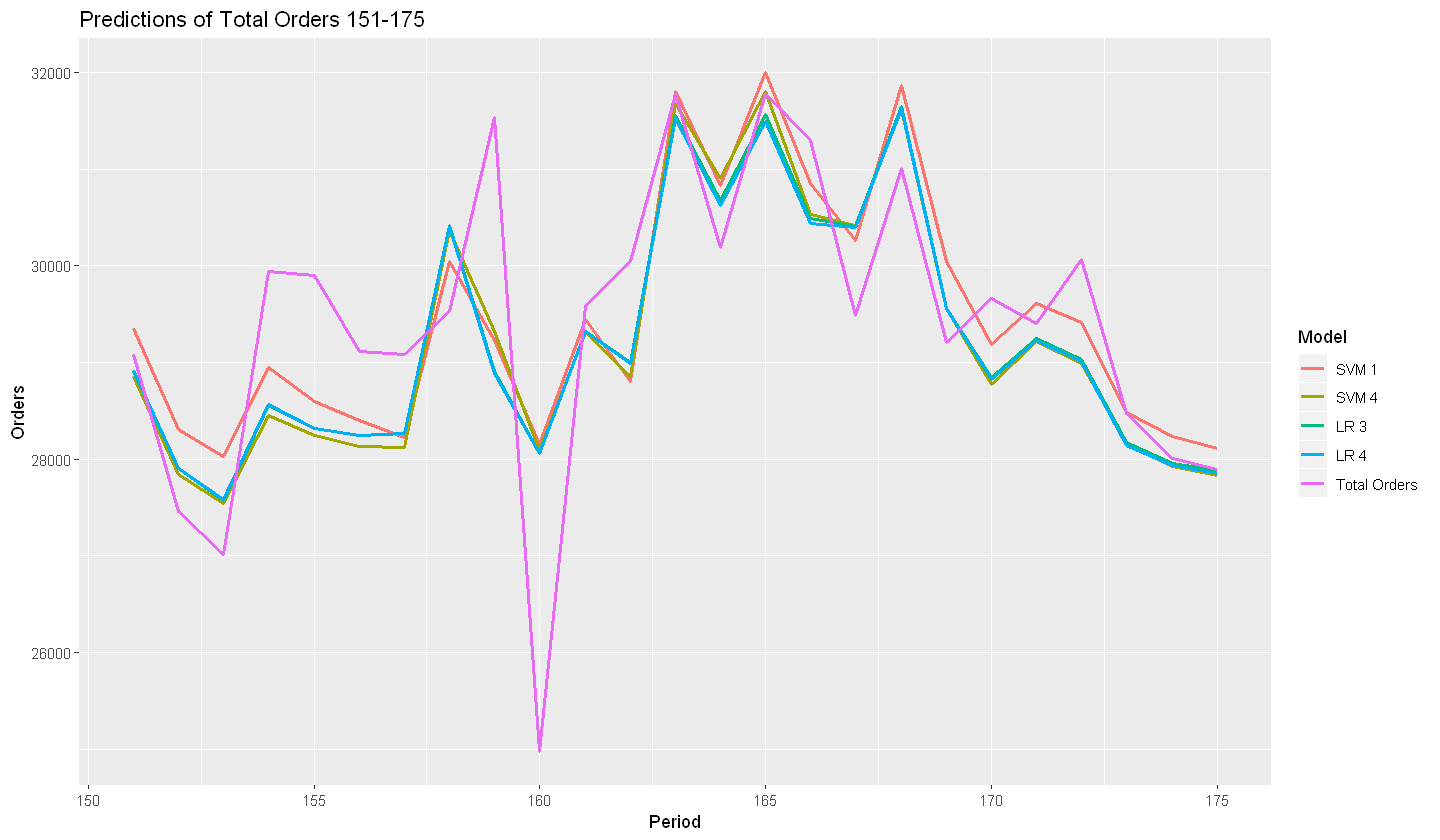

In [ ]:
svm_1<-train(Total_Orders~.,data=training_ml[,1:10],
             method="svmLinear", preProcess = c('scale'))
pred_svm_1<-round(predict(svm_1,newdata=test_ml[,1:10]))

svm_4<-train(Total_Orders~.,data=training_ml[,c(1,3,7,9,10)],
            method="svmLinear", preProcess = c('scale'))
pred_svm_4<-round(predict(svm_4,newdata=test_ml[,c(1,3,7,9,10)]))

lr_3<-lm(Total_Orders~.,data=training_ml[,c(1,3,5,7,9,10)])
pred_lr_3<-round(predict(lr_3,newdata=test_ml[,c(1,3,5,7,9,10)]))

lr_4<-lm(Total_Orders~.,data=training_ml[,c(1,3,7,9,10)])
pred_lr_4<-round(predict(lr_4,newdata=test_ml[,c(1,3,7,9,10)]))


prediction<-rbind(
     data.frame(Period=151:175,Model="SVM 1",Orders=pred_svm_1),
     data.frame(Period=151:175,Model="SVM 4",Orders=pred_svm_4),
     data.frame(Period=151:175,Model="LR 3",Orders=pred_lr_3),
     data.frame(Period=151:175,Model="LR 4",Orders=pred_lr_4),
     data.frame(Period=151:175,Model="Total Orders",Orders=test_ml$Total_Orders))

options(repr.plot.width=12, repr.plot.height=7)

p = ggplot() + 
  geom_line(data = prediction, aes(x = Period, y = Orders, color = Model),size=1) +
  xlab('Period') + ylab('Orders') +ggtitle('Predictions of Total Orders 151-175')
p

The model with the best MSE, Inter_pred and correlation is SVM with the subset of features 1. However, even if it performs well in this case, it is prone to overfitting because it uses 9 features to compute prediction. It may badly perform with some other new data. 

The second model is SVM 4. It uses few variables therefore there is not an overfitting problem. Moreover, it has a low MSE and 88% of predicted values are in a +-5% interval of real values. For this reason, since in this exercise we are interested only in accuracy, we will use **SVM 4** for our prediction.

If we had had to deploy model in production, we would have chosen **Linear Regression 4**. Its results are almost identical to results given by LR 3 but it uses one feature less. If we check the summary() function we can see that, in LM 3, FSM has a high p-value. It means that FSM is not statistically significant so it may generate overfitting and should be removed. 

Performances of LR 4 are very similar to SVM 4 ones, but LR is easier to understand. Moreover, we can empirically notice that LR 4 predictions are slightly higher than SVM 4 predictions. Since, for business purpose, we prefer to overestimate orders instead of underestimating it, LR 4 is the best model. In scientific literature LM is preferred for forecasting problems. On the contrary, SVM is typically used for classification.

# Signal Analysis
As final analysis, we will study Total Orders as a standalone signal. Since Total Orders measure is periodic, we will use the Triple Exponential Smoothing technique to study it. Parameters alpha, beta and gamma will be automatically assigned.

In [ ]:
Total_Orders_ts <- ts(data$Total_Orders[1:150],frequency=52)
fit <- HoltWinters(Total_Orders_ts)
pred_ts<-(forecast(fit))
prec_index(pred_ts$mean[1:25],data$Total_Orders[151:175])

[1] 2.106870e+06 4.788237e-01 8.000000e-01 8.000000e-02

As we expected, this prediction is worse than our SVM 4 prediction. SVM 4 uses not only historical information about TO, but also MEO information. The fact that our model produces better result than Triple Exponential Smoothing provides more guarantees regarding the correctness of our analysis. 

# Final Prediction
In this section we will perform estimation of Total Orders for periods 175-200.
In order to have a better performance, the selected model SVM 4 will be retrainded with all training data.

In [ ]:
svm_4_def<-train(Total_Orders~.,data=data_ml[1:70,c(1,3,7,9,10)],
            method="svmLinear", preProcess = c('scale'))
pred_svm_4_def<-round(predict(svm_4_def,newdata=to_predict[,c(1,3,7,9,10)]))

In order to have an idea of the precision of the solution we plot SVM_4, LR_4 and Triple Exponential Smoothing prediction.

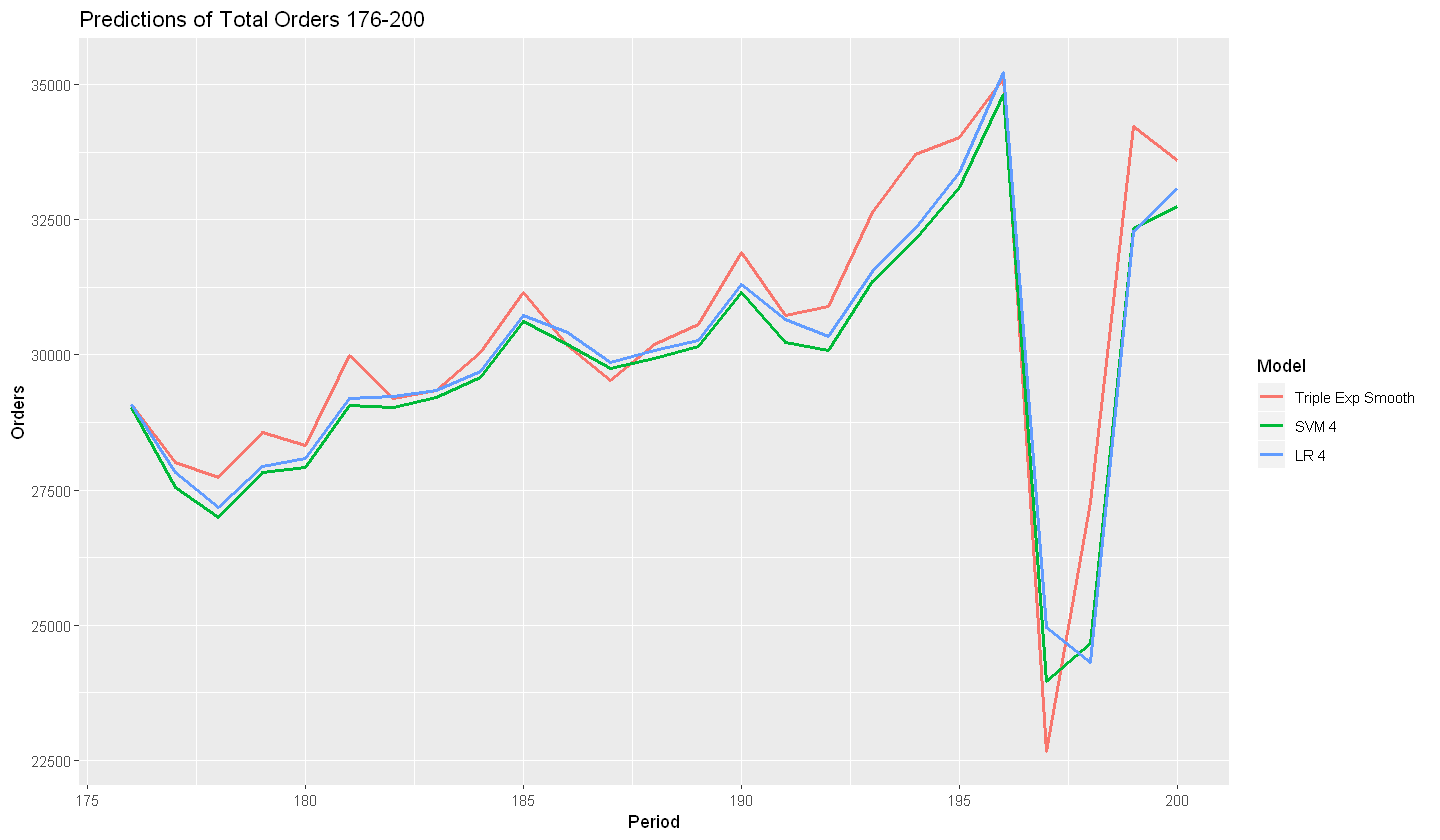

In [ ]:
Total_Orders_ts_def <- ts(data$Total_Orders[1:175],frequency=52)
fit_ts_def <- HoltWinters(Total_Orders_ts_def)
pred_ts_def<-(forecast(fit_ts_def))$mean[1:25]

lr_4_def<-lm(Total_Orders~.,data=data_ml[1:70,c(1,3,7,9,10)])
pred_lr_4_def<-round(predict(lr_4_def,newdata=to_predict[,c(1,3,7,9,10)]))

prediction_def<-rbind(
     data.frame(Period=176:200,Model="Triple Exp Smooth",Orders=pred_ts_def),
     data.frame(Period=176:200,Model="SVM 4",Orders=pred_svm_4_def),
     data.frame(Period=176:200,Model="LR 4",Orders=pred_lr_4_def))

#print data in a .csv file
write.csv(prediction_def[prediction_def$Model=="SVM 4",c(1,3)],
         'Total_Orders_Prediction.csv',row.names=FALSE)

options(repr.plot.width=12, repr.plot.height=7)

p = ggplot() + 
  geom_line(data = prediction_def, aes(x = Period, y = Orders, color = Model),size=1) +
  xlab('Period') + ylab('Orders') +ggtitle('Predictions of Total Orders 176-200')
p

# Future work
This work is only an initial analysis of the Total Orders Forecasting. Some ideas to obtain a better estimate are the following:

* Work more on tuning of neural network and random forest models that provided inaccurate estimates

* Consider regression models where the relationship with features is not linear

* Train 2 different models to estimate, for example, the first 12 periods and the following 13

* Try to obtain further data to explain for example the minimum of TO in period 160 